In [150]:
#Reference: Heng CherKeng https://storage.googleapis.com/kaggle-forum-message-attachments/345216/9642/train.py
    
import os
from trackml.score  import score_event
from sklearn.cluster.dbscan_ import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras import models
from keras import layers
from keras.layers import Masking
from keras import optimizers


TRAIN_DATA = '../../../input/train_1'

In [151]:
def load_one_event_data(event_id):
    
    particles = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-particles.csv'%event_id))
    hits  = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-hits.csv' %event_id))
    truth = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-truth.csv'%event_id))
    cells = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-cells.csv'%event_id))

    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')

    #--------------------------------------------------------
    df = truth
    return (df)

#TODO x,y,z<0
def generate_train_batch(df):
     # ..........................................
    # use volume feature in "x,y,z > 0" only
    df = df.copy()
    df = df.loc[ (df.x>0) & (df.y>0) & (df.z>0) ]
    df = df.assign(r   = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(d   = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(a   = np.arctan2(df.y, df.x))
    df = df.assign(cosa= np.cos(df.a))
    df = df.assign(sina= np.sin(df.a))
    df = df.assign(phi = np.arctan2(df.z, df.r))
    N  = len(df)

    a,r,z = df[['a', 'r', 'z' ]].values.astype(np.float32).T
    p = df['particle_id'].values.astype(np.int64)
    
    particle_ids = list(df.particle_id.unique())
    num_particle_ids = len(particle_ids)
    
    input  = np.column_stack((a,r/1000, z/3000))
    tracks = []
    
    for particle_id in particle_ids:
        if particle_id==0: continue
        t = np.where(p==particle_id)[0]
        t = t[np.argsort(r[t])]

        #TODO 
        if len(t)<10: continue
        track = input[t[:10]]
        tracks.append(track)

    tracks = np.array(tracks)
    input  = tracks[:,:5,:]
    input = np.pad(input, ((0,0),(0,5), (0,0)), 'constant')
    truth  = tracks[:,:,:]

    return (df, input, truth)




In [152]:
def batch_generator(input, truth, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, input.shape[0], input.shape[1]))
    batch_labels =  np.zeros((batch_size, truth.shape[0], truth.shape[1]))
    index = 0
   
    while True:
        batch_features = input[batch_size*index:batch_size*(index+1),:,:]
        batch_labels = truth[batch_size*index:batch_size*(index+1),:,:]
        index = index+1
        if batch_size*index > input.shape[0]:
            index=0
      
        yield batch_features, batch_labels



In [153]:
#sgd = optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)
#adam =  optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
def build_model(num_hidden, input_shape, output_shape,
                loss='mse',
                optimizer='adam', metrics=['accuracy']):
    
    inputs = layers.Input(shape=input_shape)
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(output_shape[1], activation='linear'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [154]:
def draw_train_history(history, draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    fig = plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
    return fig



In [155]:
def draw_prediction(truth, predict):
   
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)
        

    fig2 = plt.figure(figsize=(12,12))
    ax2  = fig2.add_subplot(111, projection='3d')
    fig2.patch.set_facecolor('white')
    ax2.set_xlabel('a', fontsize=16)
    ax2.set_ylabel('r', fontsize=16)
    ax2.set_zlabel('z', fontsize=16)

    predict_size = len(predict)
    predict_size = 1
    for n in range(0,predict_size,1):
        a, r, z = truth[n].T
        x = r*np.cos(a)
        y = r*np.sin(a)
        
        ea, er, ez = predict[n].T
        ex = er*np.cos(ea)
        ey = er*np.sin(ea)
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        
        
        ax2.plot(ea,er,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax2.plot(a,r,z,'.-',color = color, markersize=5)
        if n==50: plt.show(1)


   
    

In [156]:
def generate_multiple_event_data(skip=0, nevents=10):
    start = 1000
    for i in range(nevents):
        df = load_one_event_data('00000' + "{:04}".format(start+skip+i))
        df, input_tmp, truth_tmp = generate_train_batch(df)
        if i==0:
            input = input_tmp
            truth = truth_tmp
        else:
            input = np.concatenate([input, input_tmp])
            truth = np.concatenate([truth, truth_tmp])
            
    return input, truth

(101737, 10, 3)
(101737, 10, 3)


/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=24)`
  
/home/nicole/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 10, 3)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 10, 24)            2688      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 10, 3)             75        
Total params: 2,763
Trainable params: 2,763
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
10173/10173 [==============================] - 105s 10ms/step - loss: 0.0126 - acc: 0.9195 - val_loss: 0.0062 - val_acc: 0.9437
Epoch 2/10
10173/10173 [==============================] - 97s 10ms/step - loss: 0.0039 - acc: 0.9558 - val_loss: 0.0031 - val_acc: 0.9617
Epoch 3/10
10173/10173 [==============================] - 78s 8ms/step - loss: 0.0030 - acc: 0.9629 - val_loss: 0.0027 - val_ac

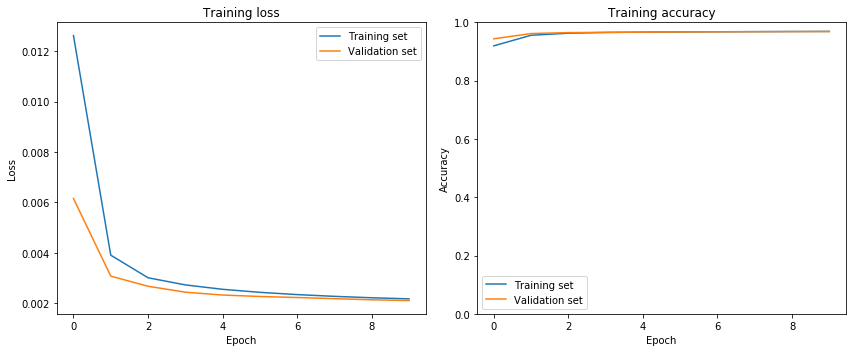

In [157]:
batch_size = 10
num_epoch = 10

if __name__ == '__main__':


    input, truth = generate_multiple_event_data(skip=200, nevents=160)
    val_input, val_truth = generate_multiple_event_data(skip=100, nevents=20)
    
    test_df = load_one_event_data('000001090')
    test_df, test_input, test_truth = generate_train_batch(test_df)
    
    
    print(input.shape)
    print(truth.shape)
    
    model = build_model(num_hidden=24, input_shape=(10,3), output_shape=(10,3))

    model.summary()

    generator = batch_generator(input, truth, batch_size)
    #val_generator = (val_input, val_truth, batch_size)
    # Train the model
    history = model.fit_generator(generator, validation_data=(val_input, val_truth),
                                  steps_per_epoch=int(input.shape[0]/batch_size), epochs=num_epoch, 
                                  shuffle = False)
    draw_train_history(history, draw_val=True);
    
    pred = model.predict(test_input)
    test_loss, test_acc = model.evaluate(test_input, test_truth)
    print(test_loss, test_acc)
    
    


[[8.1827182e-01 3.1564906e-02 7.7611003e-05]
 [8.1783605e-01 3.2060754e-02 1.2704733e-04]
 [8.1799102e-01 3.2947741e-02 2.1814468e-04]
 [8.1771100e-01 3.3469561e-02 2.7269000e-04]
 [7.9992294e-01 7.1074486e-02 4.1201669e-03]
 [7.9912138e-01 7.2875984e-02 4.3030665e-03]
 [7.7710545e-01 1.1588938e-01 8.6646331e-03]
 [7.4880093e-01 1.7217204e-01 1.4423600e-02]
 [7.0720434e-01 2.5851336e-01 2.3333333e-02]
 [6.5745521e-01 3.6099553e-01 3.3733331e-02]]
[[ 8.2782358e-01  3.8820453e-02  2.7512982e-03]
 [ 8.1986010e-01  4.5877192e-02 -5.2746572e-03]
 [ 8.1934255e-01  4.8888940e-02  2.1785125e-04]
 [ 8.1790727e-01  4.6437997e-02  3.6446713e-03]
 [ 8.0502951e-01  7.2121941e-02  5.2321814e-03]
 [ 7.8249031e-01  1.2772730e-01  3.0179154e-02]
 [ 7.6968217e-01  1.9154806e-01  5.2818220e-02]
 [ 7.4562979e-01  2.5768074e-01  7.0144072e-02]
 [ 7.1670824e-01  3.3138627e-01  9.5686585e-02]
 [ 6.8777364e-01  4.1792709e-01  1.3666643e-01]]


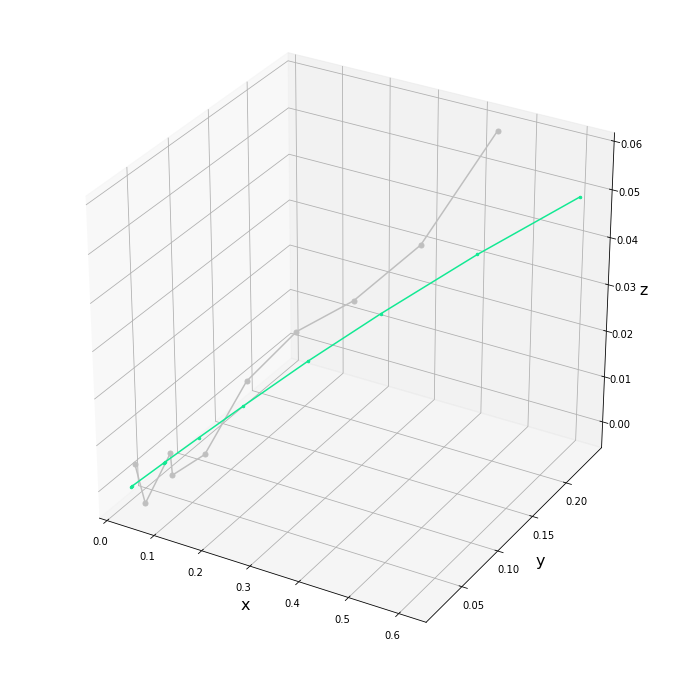

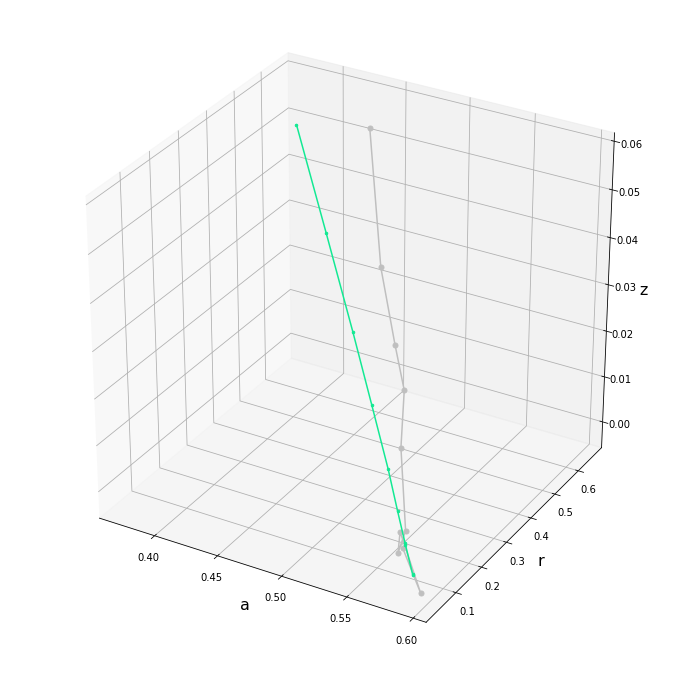

In [159]:
print(test_truth[1])

print(pred[1])
   
draw_prediction(test_truth, pred)
